In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
data = pd.read_csv("../data/edgetpu_fcfs_validation.csv")
data.head()

,model,process_type,response_time
0,ENets-S,Sequential,26.921511
1,ENets-M,Sequential,32.700539
2,ENets-L,Sequential,50.823450
3,Inception V4,Sequential,112.835169
4,SSD Mobilenet V2,Sequential,34.942150


In [5]:
typename_map = {
    "Sequential": "Dedicated",
    "Concurrent": "Shared"
}

data["process_type"] = data["process_type"].apply(lambda x: typename_map[x])

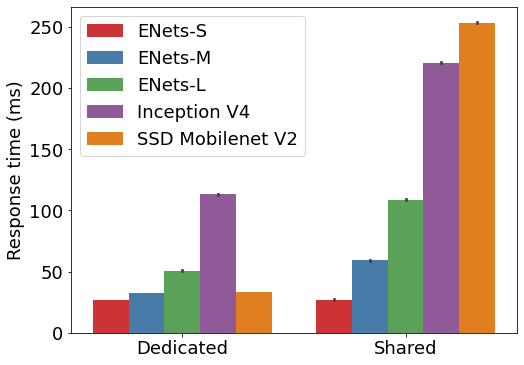

In [7]:
fig, ax = plt.subplots(figsize=(8, 6))

sns.barplot(data=data, x="process_type", y="response_time", hue="model", palette="Set1", ax=ax)

ax.tick_params(axis="both", labelsize=18)
ax.set_xlabel("")
ax.set_ylabel("Response time (ms)", fontsize=18)
ax.legend(fontsize=18)

fig.savefig("figures/edgetpu_fcfs.png", bbox_inches = 'tight', pad_inches = 0.1)

In [4]:
models = ["Efficinet-S", "Efficinet-M", "Efficinet-L", "Mobilenet v1",
          "Mobilenet v2", "Inception v3", "Inception v4"]
on_chip = [6.56, 6.74, 5.17, 4.21, 3.75, 5.67, 6.03]
off_chip = [0, 1.59, 7.13, 0, 0, 17.69, 36.13]
overhead = [17.31, 17.41, 13.7, 11.61, 10.71, 14.88, 15.71]

data = {"model": models, "on_chip_memory": on_chip, "off_chip_memory": off_chip, "switch_overhead": overhead}

df = pd.DataFrame(data=data)
df["model_size"] = df["on_chip_memory"] + df["off_chip_memory"]
df

,model,on_chip_memory,off_chip_memory,switch_overhead,model_size
0,Efficinet-S,6.56,0.00,17.31,6.56
1,Efficinet-M,6.74,1.59,17.41,8.33
2,Efficinet-L,5.17,7.13,13.70,12.30
3,Mobilenet v1,4.21,0.00,11.61,4.21
4,Mobilenet v2,3.75,0.00,10.71,3.75
5,Inception v3,5.67,17.69,14.88,23.36
6,Inception v4,6.03,36.13,15.71,42.16


In [5]:
df_melt = df.melt(id_vars="model", value_vars=["on_chip_memory", "off_chip_memory"])
df_pivot = df_melt.pivot_table(index="model", columns="variable", values="value")
df_pivot = df_pivot[["on_chip_memory", "off_chip_memory"]]
df_pivot

variable,on_chip_memory,off_chip_memory
model,,
Efficinet-L,5.17,7.13
Efficinet-M,6.74,1.59
Efficinet-S,6.56,0.00
Inception v3,5.67,17.69
Inception v4,6.03,36.13
Mobilenet v1,4.21,0.00
Mobilenet v2,3.75,0.00


In [6]:
order = ["Mobilenet v2", "Mobilenet v1", "Efficinet-L", "Inception v3", "Inception v4", "Efficinet-S", "Efficinet-M"]

df = df.set_index("model")
df = df.loc[order]

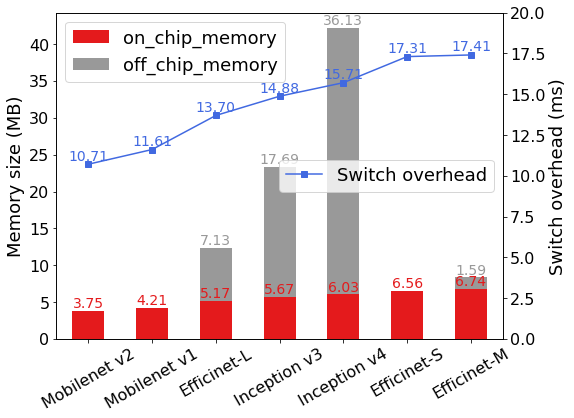

In [7]:
fig, ax = plt.subplots(figsize=(8, 6))
ax_twin = ax.twinx()


df_pivot.loc[order].plot.bar(stacked=True, ax=ax, cmap="Set1")
ax_twin.plot(df.index.values, df["switch_overhead"], ls="-", marker='s', color="royalblue", label="Switch overhead")

ax.legend(fontsize=18)
ax_twin.legend(fontsize=18, loc=5)

ax.tick_params(axis="both", labelsize=16)
ax.tick_params(axis="x", rotation=30)
ax_twin.tick_params(axis="y", labelsize=16)

ax.set_xlabel("")
ax.set_ylabel("Memory size (MB)", fontsize=18)
ax_twin.set_ylabel("Switch overhead (ms)", fontsize=18)
ax_twin.set_ylim([0, 20])

# annotate bar values
for patch in ax.patches:
    if patch.get_height() != 0:
        ax.annotate("%.2f" % patch.get_height(),
                    (patch.get_x() + patch.get_width()/2, (patch.get_height()+patch.get_y()) + 1),
                    ha='center', va='center', fontsize=14, color=patch.get_facecolor())

# annotate line values
for model, overhead in zip(df.index.values, df["switch_overhead"]):
    ax_twin.annotate("%.2f" % overhead, (model, overhead+.5), ha='center', va='center', fontsize=14, color='royalblue')

fig.savefig("figures/switch_overhead.pdf", bbox_inches = 'tight', pad_inches = 0.1)